In [1]:
import numpy as np
np.random.seed(1)
N=1000
def generate_experiment_data(size=N):
    d1 = np.random.normal(loc = 0.0, scale = 1.0, size = N) + np.random.randn(N) * 0.1
    d2 = np.random.normal(loc = 2.0, scale = 1.0, size = N) + np.random.randn(N) * 0.1
    return d1,d2
Wafer1, Wafer2 = generate_experiment_data(size=N)
print(np.shape(Wafer1))

(1000,)


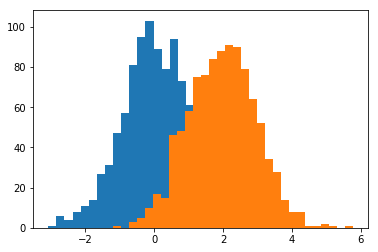

In [3]:
import matplotlib.pyplot as plt
plt.hist(Wafer1,bins=30)
plt.hist(Wafer2, bins=30)
plt.show()

In [21]:
from scipy.stats import gaussian_kde

def generate_train_data(Data1, Data2):
    pdf1 = gaussian_kde(Data1)
    pdf2 = gaussian_kde(Data2)
    
    Len = len(Data1)

    X1 = np.linspace(min(Data1), max(Data1), num=Len)
#     X2 = np.linspace(min(Data2), max(Data2), num=Len)
    X2 = X1
    y1 = pdf1(X1)
    y2 = pdf2(X2)
    return X1,y1,X2,y2

X1,y1,X2,y2 = generate_train_data(Wafer1, Wafer2)
print(np.shape(X1), np.shape(y1), type(X2), type(y2))

(1000,) (1000,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [22]:
from scipy.fftpack import fft,ifft

def do_fft(X1,y1,X2,y2):
    # X1
    yy1 = fft(y1)
    yy1_amp = abs(yy1) # amplitude for y1
    # yy1_amp = yy1_amp / (N/2)
    yy1_phase = np.angle(yy1) # phase for y1

    xx1_amp = X1
    xx1_phase = X1

    # X2
    yy2 = fft(y2)
    yy2_amp = abs(yy2) # amplitude for y2
    # yy2_amp = yy2_amp / (N/2)
    yy2_phase = np.angle(yy2) # phase for y2

    xx2_amp = X2
    xx2_phase = X2
    return xx1_amp,yy1_amp,xx1_phase,yy1_phase,xx2_amp,yy2_amp,xx2_phase,yy2_phase

xx1_amp,yy1_amp,xx1_phase,yy1_phase,xx2_amp,yy2_amp,xx2_phase,yy2_phase = do_fft(X1,y1,X2,y2)

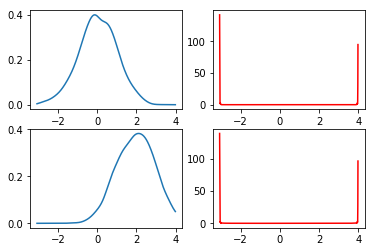

In [25]:
plt.subplot(221)
plt.plot(X1, y1)

plt.subplot(222)
plt.plot(xx1_amp, yy1_amp, 'r')

plt.subplot(223)
plt.plot(X2, y2)

plt.subplot(224)
plt.plot(xx2_amp, yy2_amp, 'r')

plt.show()

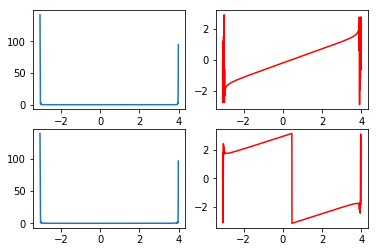

In [26]:
plt.subplot(221)
plt.plot(xx1_amp, yy1_amp)

plt.subplot(222)
plt.plot(xx1_phase, yy1_phase, 'r')

plt.subplot(223)
plt.plot(xx2_amp, yy2_amp)

plt.subplot(224)
plt.plot(xx2_phase, yy2_phase, 'r')

plt.show()

(141.4907345893302+0j)


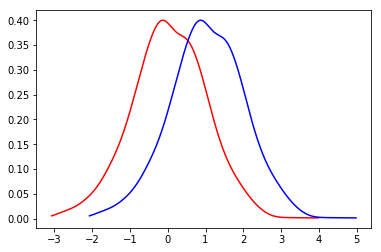

In [27]:
def reconstruct_data(mag, phase):
    y_real = mag * np.cos(phase)
    y_imag = mag * np.sin(phase)
    number = len(y_real)
    print(np.complex(y_real[0], y_imag[0]))
    y = np.array([np.complex(y_real[i], y_imag[i]) for i in range(number)])
    return ifft(y)

y_test = reconstruct_data(yy1_amp, yy1_phase)

plt.plot(X1, y_test, 'r')
plt.plot(X1+1, y1, 'b')
plt.show()

In [56]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

def plot_data(X, y, predicted):
    plt.scatter(X, y, marker='x')
    plt.plot(X, predicted, c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def get_param():
    param = {
        'seed': 0,
        'eta': 0.1,
        'colsample_bytree': 0.5,
        'silent': 1,
        'objective': 'reg:linear',
        'max_depth': 4,
        'min_child_weight': 3,
        'nthread': 4,
        'eval_metric': 'rmse'
    }
    
    return param

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    print('test')
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

def xgboost_algorithm(X, y, param=None, num_boost_round=100, maglify=1.0):
    y = np.multiply(y, maglify)
    real_param = param
    if param is None:
        real_param = get_param()
    data = pd.DataFrame(np.column_stack([X]),columns=['x'])
    label = pd.DataFrame(np.column_stack([y]))
    print(data.head())
    print(label.head())
    dtrain = xgb.DMatrix(data, label=label)
    mode = xgb.train(real_param, dtrain=dtrain, num_boost_round=num_boost_round, feval=xg_eval_mae, maximize=False)
    dtest = xgb.DMatrix(data)
    predicted = mode.predict(dtest)
    predicted = np.divide(predicted, maglify)
    return mode, predicted

In [60]:
y1 = np.sort(y1)
y2 = np.sort(y2)
xx1_amp,yy1_amp,xx1_phase,yy1_phase,xx2_amp,yy2_amp,xx2_phase,yy2_phase = do_fft(X1,y1,X2,y2)
y_amp_mode, y_amp_predicted = xgboost_algorithm(yy2_amp, yy1_amp)
y_phase_mode, y_phase_predicted = xgboost_algorithm(yy2_phase, yy1_phase)

            x
0  138.636587
1   86.815929
2   31.282512
3   20.065127
4   16.395735
            0
0  141.490735
1   83.278179
2   37.367980
3   20.993169
4   15.208276
          x
0  0.000000
1  1.264182
2  1.586019
3  1.592133
4  1.556329
          0
0  0.000000
1  1.208617
2  1.593623
3  1.632592
4  1.548350


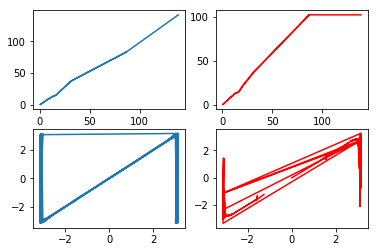

In [61]:
plt.subplot(221)
plt.plot(yy2_amp, yy1_amp)

plt.subplot(222)
plt.plot(yy2_amp, y_amp_predicted, 'r')

plt.subplot(223)
plt.plot(yy2_phase, yy1_phase)

plt.subplot(224)
plt.plot(yy2_phase, y_phase_predicted, 'r')

plt.show()

(141.48046258027162-1.70499418954488j)


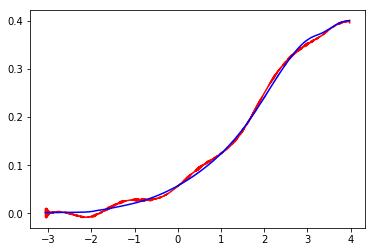

In [68]:
y_predicted = reconstruct_data(yy1_amp, y_phase_predicted)
plt.plot(X1, y_predicted, 'r')
plt.plot(X1, y1, 'b')
plt.show()

In [70]:
def compare_equal(data1, data2, precision=0.01):
    delta = abs(data1)*precision
    if data2 > data1 - delta and data2 < data1 + delta:
        return True
    else:
        return False
    
def compute_accuracy(Data1, Data2, sort=True, precision=0.01):
    X1 = Data1
    X2 = Data2
    if sort:
        X1 = np.sort(Data1)
        X2 = np.sort(Data2)
    correct_prediction = 0
    TotalCount = len(X1)
    for i in range(0, TotalCount):
        if compare_equal(X1[i], X2[i], precision):
            correct_prediction +=1
    
    accuracy = correct_prediction/TotalCount
    return accuracy
        
accuracy = compute_accuracy(y_predicted, y1, sort=True, precision=0.1)
print(accuracy)

0.64


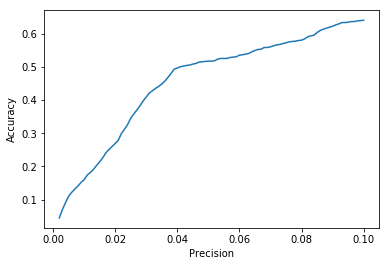

0.64


In [71]:
precisions = np.arange(0.1, 0.001, -0.001)
accuracies = [compute_accuracy(y_predicted, y1, sort=True, precision=i) for i in precisions]
import matplotlib.pyplot as plt
plt.plot(precisions, accuracies)
plt.xlabel('Precision')
plt.ylabel('Accuracy')
plt.show()
print(np.max(accuracies))

In [74]:
def compute_accuracy_with_size(size_list, precision=0.01):
    accuracies = []
    for i in size_list:
        Wafer1, Wafer2 = generate_experiment_data(size=i)
        X1,y1,X2,y2 = generate_train_data(Wafer1, Wafer2)
        y1 = np.sort(y1)
        y2 = np.sort(y2)
        xx1_amp,yy1_amp,xx1_phase,yy1_phase,xx2_amp,yy2_amp,xx2_phase,yy2_phase = do_fft(X1,y1,X2,y2)
        y_amp_mode, y_amp_predicted = xgboost_algorithm(yy2_amp, yy1_amp)
        y_phase_mode, y_phase_predicted = xgboost_algorithm(yy2_phase, yy1_phase)
        y_predicted = reconstruct_data(yy1_amp, y_phase_predicted)
        accuracy = compute_accuracy(y_predicted, y1, sort=True, precision=precision)
        accuracies.append(accuracy)
        
    return accuracies
        
size_list = [i for i in range(100, 10000, 1000)]
# size_list = [100,10000]
accuracies = compute_accuracy_with_size(size_list, 0.05)

            x
0  135.509476
1   94.607057
2   33.829942
3   20.400976
4   17.011167
            0
0  163.558764
1   76.183497
2   36.388211
3   21.511259
4   16.263560
          x
0  0.000000
1  1.177257
2  1.788526
3  1.462053
4  1.616854
          0
0  0.000000
1  1.322509
2  1.565955
3  1.566224
4  1.565744
(163.5585589715176+0.2593634851031938j)
            x
0  140.162122
1   88.832232
2   28.468587
3   23.070082
4   15.728432
            0
0  149.571842
1   77.701659
2   31.218733
3   18.013312
4   14.130931
          x
0  0.000000
1  1.271007
2  1.578733
3  1.538646
4  1.569729
          0
0  0.000000
1  1.349994
2  1.665631
3  1.577681
4  1.582571
(149.5635958252979+1.5709144217646498j)
            x
0  125.146797
1   90.326088
2   37.062214
3   17.435978
4   14.849855
            0
0  163.564188
1   80.559417
2   33.929762
3   23.204131
4   15.713100
          x
0  0.000000
1  1.123855
2  1.791971
3  1.627730
4  1.500152
          0
0  0.000000
1  1.333302
2  1.587001
3  1.559

[100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100] 0.665


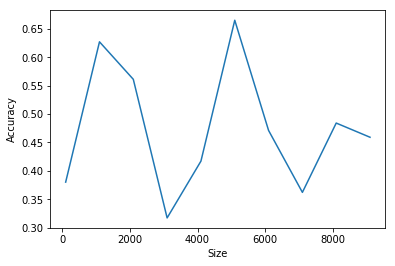

0.47430000000000005


In [75]:
print(size_list, np.max(accuracies))
plt.plot(size_list, accuracies)
plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.show()
print(np.average(accuracies))